In [28]:
from IPython.core.interactiveshell  import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

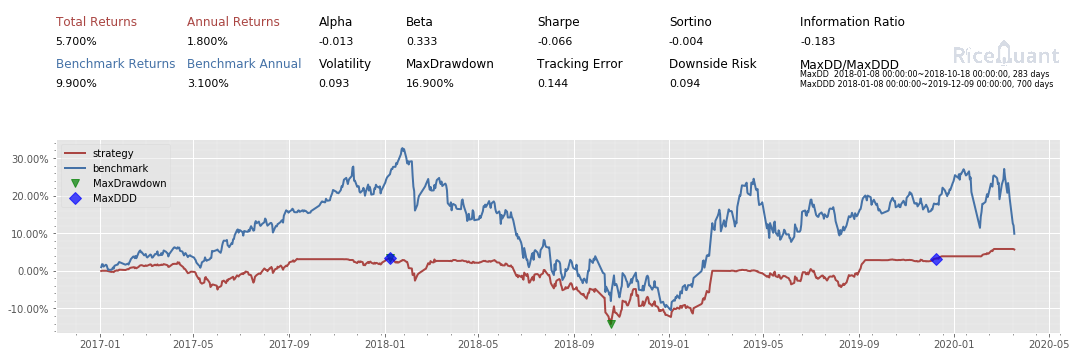

In [64]:
import os
from rqalpha.api import *
from rqalpha import run_func
import talib
from rqalpha.model.portfolio import Portfolio
import pandas as pd
import pdb


config = {
    "base": {
        "start_date": "2017-01-01",
        "end_date": "2020-03-18",
        "benchmark": "000300.XSHG",
        "data_bundle_path": "bundle",
        "accounts": {
            "stock": 200000
        }
    },
    "extra": {
        "log_level": "error",
    },

    "mod": {
        "sys_progress": {
            "enabled": True,
            "show": True,
        },
        "sys_analyser": {
            "enabled": True,
            "plot": True,
        },
        "sys_transaction_cost": {
            "enabled": True,
            "cn_stock_min_commission": 5,
            "commission_multiplier": 1.5,
        },
        "sys_simulation": {
                "enabled": True,
                "slippage": 0.005
        },
    },
}

close = []
def init(context):
    context.s1 = '510500.XSHG'

    context.MIDDLEPERIOD = 20
    context.SHORTPERIOD = 12
    context.LONGPERIOD = 26
    context.SMOOTHPERIOD = 9
    context.OBSERVATION = 100

    context.RSI_PERIOD = 14
    context.HIGH_RSI = 85
    context.LOW_RSI = 20
    
    context.BOLL_PERIOD = 20
    context.BOLL_FACTOR = 2
    # 超卖标志
    context.OVERSOLDFLAG = 0
    # 超买标志
    context.OVERBOUGHTFLAG = 0

def handle_bar(context, bar_dict):  
    BUYRATIO = 0.05
    SELLRATIO = 1
    prices = history_bars(context.s1, context.OBSERVATION,'1d','close')
    # Current Position
    curpos = context.portfolio.positions[context.s1].quantity
    # Current Cash
    curcash = context.portfolio.cash
    
    ######################################################################
    # 用Talib计算MACD取值，得到三个时间序列数组，分别为 macd, signal 和 hist
    macd, signal, hist = talib.MACD(prices, context.SHORTPERIOD,context.LONGPERIOD, context.SMOOTHPERIOD)
    
    # 卖出策略1
    # 如果macd从上往下跌破macd_signal。
    # 可能存在错误卖出，所以减仓比例为0.2
    if macd[-1] - signal[-1] < 0 and macd[-2] - signal[-2] > 0:
        # 计算现在portfolio中股票的仓位
        curPosition = context.portfolio.positions[context.s1].quantity
        #进行清仓
        if curPosition > 0:            
            order_shares(context.s1,- curPosition * SELLRATIO * 0.1)
    
    # 卖出策略2
    # 绝对收益率超过10%可以卖出90%以上的仓位。
    if curpos > 0:
        cumReturnRatio = ( prices[-1]  - context.portfolio.positions[context.s1].avg_price)/context.portfolio.positions[context.s1].avg_price
        if cumReturnRatio >= 0.1:                                
            order_shares(context.s1,- curpos * SELLRATIO )
            
    # 卖出策略3
    # 超买卖出
    # 用Talib计算RSI值
    rsi_data = talib.RSI(prices[-context.RSI_PERIOD-1:], timeperiod=context.RSI_PERIOD)[-1]
    # 当RSI大于设置的上限阀值，清仓该股票
    if rsi_data > context.HIGH_RSI and curpos > 0:
        order_shares(context.s1,- curpos * SELLRATIO)

    
    
    #######################################################################
    # 买进策略1
    # 如果短均线从下往上突破长均线，为入场信号
    # 为避免错误交易信号，增加判断当日较昨日是否下跌,若下跌则不买进
    if macd[-1] - signal[-1] > 0 and macd[-2] - signal[-2] < 0 and  prices[-2] < prices[-1]:
        # 按1%-5%比例建仓，建仓过程要缓
        #order_target_percent(context.s1, 0.01)
        order_value(context.s1,context.portfolio.cash * BUYRATIO)
    
      
    # 计算Bollinger(20,2)
    mediumline = talib.EMA(prices, context.BOLL_PERIOD)   
    # EMA(20)均值标准差
    stddev = talib.STDDEV(prices,context.BOLL_PERIOD)
    # Bollingar upper line
    upperLine = mediumline + context.BOLL_FACTOR * stddev 
    # Bollingar low line
    lowerLine = mediumline - context.BOLL_FACTOR * stddev 
    
    # 买进策略2——跌破Bollinger(20,2）下轨支持位的买进
    # 如果当日（T）收盘价下穿boll(20,2)下轨，则可以在T+2买进
    if prices[-2] < lowerLine[-2] or prices[-3] < lowerLine[-3] or prices[-4] < lowerLine[-4]:
        order_value(context.s1,context.portfolio.cash * BUYRATIO)
        
    # 买进策略3
    # 当RSI小于设置的下限阀值，用剩余cash的一定比例补仓该股
    if rsi_data < context.LOW_RSI:
        # 如果剩余的现金不够一手 - 100shares，那么会被ricequant 的order management system reject掉
        order_value(context.s1, context.portfolio.cash * BUYRATIO)

#pdb.set_trace() 
results = run_func(init=init, handle_bar=handle_bar, config=config)


In [38]:
results['sys_analyser']['summary']['benchmark_total_returns']
#results['sys_analyser']['portfolio']['']

0.099

In [48]:
results['sys_analyser']['trades'].shape[0]/3


61.333333333333336

In [59]:
results['sys_analyser']['trades']

,trading_datetime,order_book_id,symbol,side,position_effect,exec_id,tax,commission,last_quantity,last_price,order_id,transaction_cost
datetime,,,,,,,,,,,,
2017-01-03 15:00:00,2017-01-03 15:00:00,510500.XSHG,南方500ETF,BUY,OPEN,15846107284607,0,11.957490,1500.0,6.643,15846107277673,11.957490
2017-01-13 15:00:00,2017-01-13 15:00:00,510500.XSHG,南方500ETF,SELL,CLOSE,15846107284608,0,5.000000,150.0,6.445,15846107277674,5.000000
2017-01-16 15:00:00,2017-01-16 15:00:00,510500.XSHG,南方500ETF,BUY,OPEN,15846107284609,0,11.384037,1500.0,6.324,15846107277676,11.384037
2017-01-17 15:00:00,2017-01-17 15:00:00,510500.XSHG,南方500ETF,BUY,OPEN,15846107284610,0,10.717963,1400.0,6.380,15846107277678,10.717963
2017-01-18 15:00:00,2017-01-18 15:00:00,510500.XSHG,南方500ETF,BUY,OPEN,15846107284611,0,9.958666,1300.0,6.384,15846107277680,9.958666
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-06 15:00:00,2020-02-06 15:00:00,510500.XSHG,南方500ETF,BUY,OPEN,15846107284770,0,11.019946,1600.0,5.740,15846107277966,11.019946
2020-02-14 15:00:00,2020-02-14 15:00:00,510500.XSHG,南方500ETF,BUY,OPEN,15846107284771,0,10.615212,1500.0,5.897,15846107277968,10.615212
2020-02-21 15:00:00,2020-02-21 15:00:00,510500.XSHG,南方500ETF,SELL,CLOSE,15846107284772,0,50.230744,6700.0,6.248,15846107277969,50.230744
